#### Import libraries

In [26]:
import numpy as np
import plotly.express as px
from plotly.io import write_image
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from IPython.display import Image

#### Initialize parameters

In [27]:
n = 10000 # number of samples
d = 1000 # number of dimensions
num_clusters = 10 # number of clusters
cutoff = 1000 # number of samples to use for the initial clustering

filtered_num_clusters = 7 # classes to use for initial clustering
extra_num_clusters = num_clusters - filtered_num_clusters # number of clusters to add

#### Generate data with all clusters

In [28]:
X, real_clusters = make_blobs(
    n_samples=n,
    n_features=d,
    centers=num_clusters,
    cluster_std=10,
    shuffle=True,
    random_state=42
    )

#### Filter initial clustering data (train) to selected clusters

In [29]:
real_train_clusters = real_clusters[:cutoff]
X_train = X[:cutoff]
X_test = X[cutoff:]

X_train = X_train[np.isin(real_train_clusters, range(filtered_num_clusters))]
real_train_clusters = real_train_clusters[np.isin(real_train_clusters, range(filtered_num_clusters))]

np.unique(real_train_clusters)

array([0, 1, 2, 3, 4, 5, 6])

This results in X_train having only 7 clusters, while X_test keeps all 10 clusters.
This way X_test will have to introduce new clusters.

#### Agglomerative clustering

In [30]:
Z = linkage(X_train, 'ward')
train_clusters = fcluster(Z, filtered_num_clusters, criterion='maxclust')-1

#### Training KNN classifier on the cluster data to use for inference of test data

In [31]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, train_clusters)
test_clusters = knn.predict(X_test)

confusion_matrix(real_clusters[cutoff:], test_clusters)

array([[  0,   0,   0,   0,   0,   0, 891,   0,   0,   0],
       [  0,   0,   0,   0, 899,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 894,   0,   0,   0,   0],
       [904,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 901,   0,   0,   0,   0,   0,   0],
       [  0,   0, 906,   0,   0,   0,   0,   0,   0,   0],
       [  0, 915,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 82, 371, 152,  64,  98,  59,  78,   0,   0,   0],
       [280, 186,  46, 187,  31, 142,  31,   0,   0,   0],
       [204, 140,  84,  89,  12, 119, 235,   0,   0,   0]])

As the confusion matrix shows, the predicted classes overlap, and the 3 clusters that were not present in the training data are not predicted at all.

#### Calculate distance between test data and clusters

In [32]:
dists = knn.kneighbors(X_test, return_distance=True)[0].flatten()
dists

array([410.25542439, 427.95937742, 486.51965528, ..., 414.04245832,
       431.23020694, 416.52653392])

#### Histogram of distances

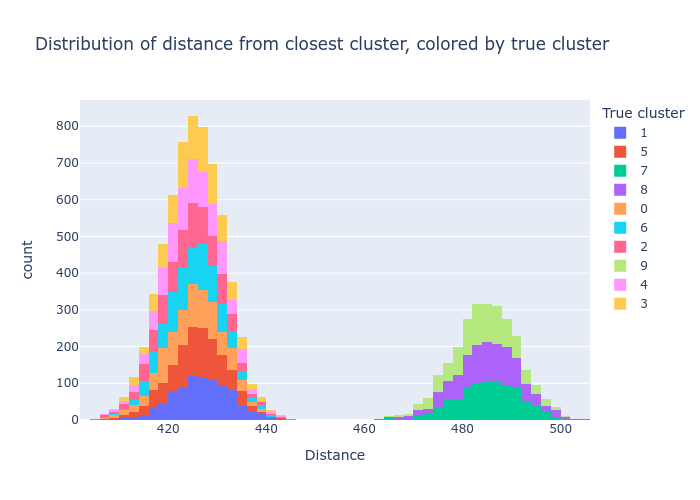

In [33]:
fig = px.histogram(
    x=dists,
    color=real_clusters[cutoff:],
    color_discrete_sequence=px.colors.qualitative.Plotly,
    barmode='stack',
    labels={'x':'Distance', 'color':'True cluster', 'value':'Count'},
    nbins=100,
    title='Distribution of distance from closest cluster, colored by true cluster',
    )

write_image(fig, 'images/distance_distributions.png')
Image('images/distance_distributions.png')

Data points that are close to the clusters are more likely to be assigned to the correct cluster. The histogram shows that there are 2 separate distributions of data points, one with the 7 clusters that were present in the training data, and one for the 3 clusters that were not present in the training data.

#### Fit Gaussian Mixture Model to separate the points that need new clusters

In [34]:
gaussian = GaussianMixture(n_components=2, random_state=42)
gaussian.fit(dists.reshape(-1, 1))

probs = gaussian.predict_proba(dists.reshape(-1, 1))
assignments = np.argmax(probs, axis=1)

#### Get average distance of each group in ascending order

In [35]:
avg_dists = np.array([dists[assignments == i].mean() for i in range(2)])
smaller_avg_dist = np.argmin(avg_dists)
avg_dists

array([425.17216895, 484.68583689])

#### Plot average distance of each group

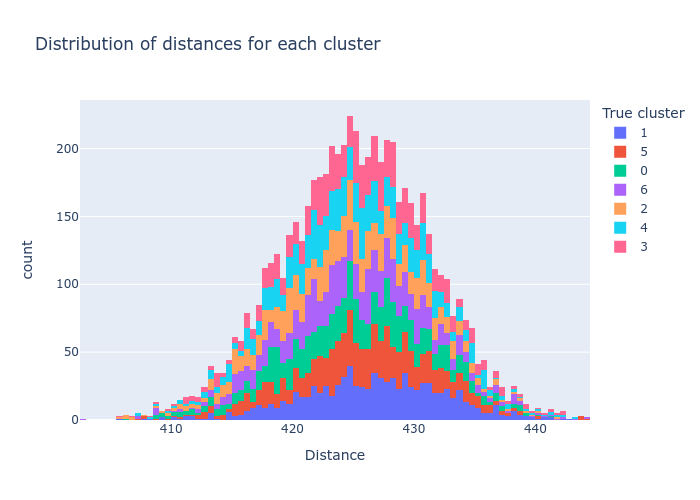

In [36]:
fig = px.histogram(
    x=dists[assignments==smaller_avg_dist],
    color=real_clusters[cutoff:][assignments==smaller_avg_dist],
    color_discrete_sequence=px.colors.qualitative.Plotly,
    barmode='stack',
    labels={'x':'Distance', 'color':'True cluster', 'value':'Count'},
    nbins=100,
    title='Distribution of distances for each cluster'
    )
write_image(fig, 'images/separated_group0.png')
Image(filename='images/separated_group0.png')

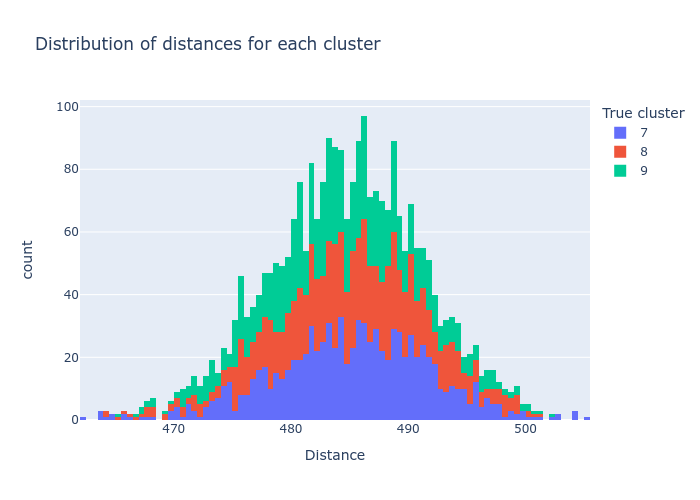

In [37]:
fig = px.histogram(
    x=dists[assignments!=smaller_avg_dist],
    color=real_clusters[cutoff:][assignments!=smaller_avg_dist],
    color_discrete_sequence=px.colors.qualitative.Plotly,
    barmode='stack',
    labels={'x':'Distance', 'color':'True cluster', 'value':'Count'},
    nbins=100,
    title='Distribution of distances for each cluster'
    )
write_image(fig, 'images/separated_group1.png')
Image(filename='images/separated_group1.png')


#### Use the separation to cluster new data

In [38]:
X_test_to_classify = X_test[assignments==smaller_avg_dist]
test_to_classify_clusters = knn.predict(X_test_to_classify)
X_test_to_cluster = X_test[assignments!=smaller_avg_dist]
Z = linkage(X_test_to_cluster, 'ward')
test_to_cluster_clusters = fcluster(Z, extra_num_clusters, criterion='maxclust')-1

Use the KNN classifer trained on the initial clustering to predict the clusters of the test data that are close to the original clusters. Fit a new agglomerative clustering to the data points that are far from the original clusters, thus forming new clusters.

#### Compare the results of the KNN + new clustering technique with the ground truth

In [39]:
test_clusters = np.zeros(len(real_clusters[cutoff:]))
test_clusters[assignments==smaller_avg_dist] = test_to_classify_clusters
test_clusters[assignments!=smaller_avg_dist] = test_to_cluster_clusters + filtered_num_clusters
test_clusters = test_clusters.astype(int)

In [40]:
confusion_matrix(real_clusters[cutoff:], test_clusters)

array([[  0,   0,   0,   0,   0,   0, 891,   0,   0,   0],
       [  0,   0,   0,   0, 899,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 894,   0,   0,   0,   0],
       [904,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 901,   0,   0,   0,   0,   0,   0],
       [  0,   0, 906,   0,   0,   0,   0,   0,   0,   0],
       [  0, 915,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 904,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 903],
       [  0,   0,   0,   0,   0,   0,   0,   0, 883,   0]])

The results are perfect, however the clusters were not overlapping so their distance distribution was perfectly separable. There was also only 2 distinct distributions.